In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_5

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
electrons_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(electrons_df, config=FIVE_LAYERS)
del electrons_df
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
photons_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(photons_df, config=FIVE_LAYERS)
del photons_df
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
pi0_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(pi0_df, config=FIVE_LAYERS)
del pi0_df
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
pi_charged_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(pi_charged_df, config=FIVE_LAYERS)
del pi_charged_df
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330809


## 1.5 Combine Different Particles

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

In [12]:
# combine the datasets
experiment = electrons + photons + pi0 + pi_char

# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

MemoryError: Unable to allocate 3.80 GiB for an array with shape (320, 1592160) and data type float64

# 2. Train Model With No Changes

In [14]:
# split data into training and testing, next train XGBoost model
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
print(experiment.X_test.shape)

(318433, 22)


In [15]:
max_depth_range = [6, 7]
learning_rate_range = [0.18, 0.19]
subsample_range = [0.8, 0.9, 1.0]
colsample_bytree_range = [0.8, 0.9, 1.0]
num_rounds_grid = [500, 600, 700]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range,
        learning_rate_range,
        subsample_range,
        colsample_bytree_range,
        num_rounds_grid,
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, subsample, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 3699.6760204696243
INFO: Trained XGBoost model; mean squared error: 3677.4684116218427
INFO: Trained XGBoost model; mean squared error: 3663.4558027776957
INFO: Trained XGBoost model; mean squared error: 3690.604423289339
INFO: Trained XGBoost model; mean squared error: 3662.6637240118857
INFO: Trained XGBoost model; mean squared error: 3646.7812401147303
INFO: Trained XGBoost model; mean squared error: 3715.579806506434
INFO: Trained XGBoost model; mean squared error: 3682.214464615573
INFO: Trained XGBoost model; mean squared error: 3660.224155620133
INFO: Trained XGBoost model; mean squared error: 3690.15891121433
INFO: Trained XGBoost model; mean squared error: 3661.336864052551
INFO: Trained XGBoost model; mean squared error: 3638.2851596843534
INFO: Trained XGBoost model; mean squared error: 3688.0917679689414
INFO: Trained XGBoost model; mean squared error: 3661.558081466638
INFO: Trained XGBoost model; mean squared error: 3640.73

In [16]:
experiment_hyperparams.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,subsample,colsample_bytree,n_estimators,Nodes NO
77,3581.204092,reg:squarederror,7,0.18,1.0,0.9,700,81295
74,3587.733536,reg:squarederror,7,0.18,1.0,0.8,700,81958
101,3588.621685,reg:squarederror,7,0.19,1.0,0.8,700,81747
80,3590.757048,reg:squarederror,7,0.18,1.0,1.0,700,81555
76,3593.192901,reg:squarederror,7,0.18,1.0,0.9,600,69912
...,...,...,...,...,...,...,...,...
3,3690.604423,reg:squarederror,6,0.18,0.8,0.9,500,30243
33,3694.873993,reg:squarederror,6,0.19,0.8,1.0,500,30268
0,3699.676020,reg:squarederror,6,0.18,0.8,0.8,500,30327
27,3700.308510,reg:squarederror,6,0.19,0.8,0.8,500,30264


In [17]:
utils.save_table_df(
    experiment_hyperparams.sort_values(by="MSE"),
    filename="5.0-experiment-hyperparams.csv",
)

In [18]:
# hyperparameters used
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}

experiment.train_xgboost_model(params)

INFO: Trained XGBoost model; mean squared error: 3655.5840579032492


3655.5840579032492

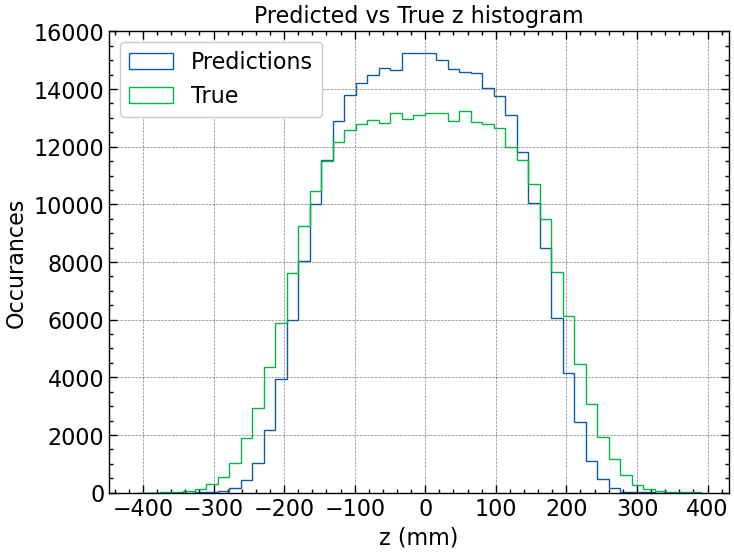

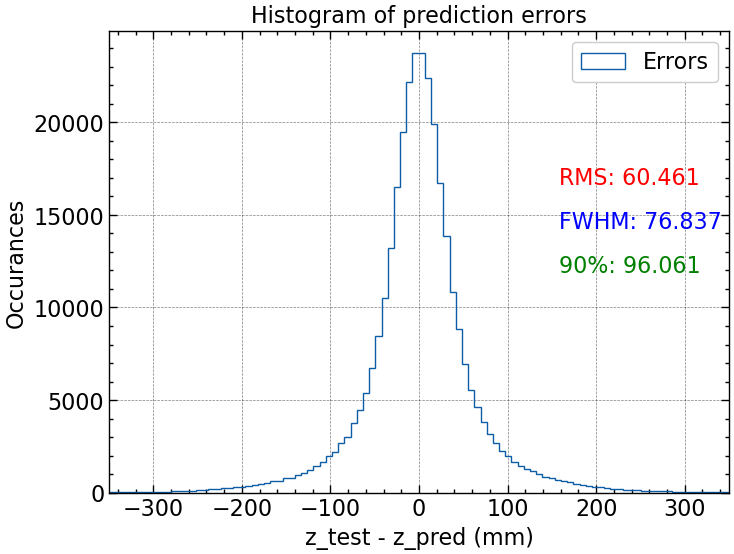

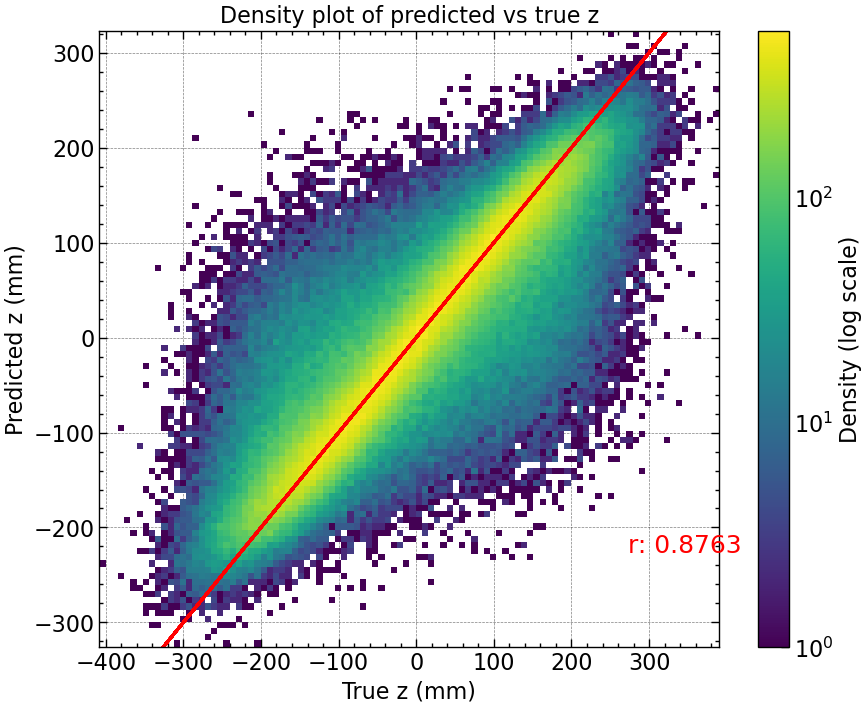

In [19]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

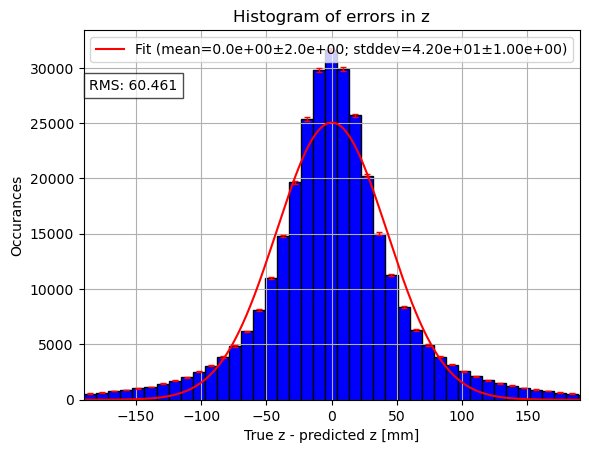

(array([2.50558526e+04, 5.13029514e-02, 4.23894160e+01]),
 array([1181.86244939,    1.51033297,    1.3103152 ]))

In [20]:
utils.fit_gaussian_to_data(
    data=Y_test - Y_pred,
    initial_guesses=[8000, 0, 36],
    binnum=100,
    plot=True,
    maxfev=None,
    x_label="True z - predicted z [mm]",
    y_label=None,
    title="Histogram of errors in z",
    combine_bins=True,
    binnum_correction=False,
    xlim=(-190, 190),
)